# SMAI 

## Assignment 4

### Question 2
### Random Forest and Boosting

In this assignment, we will implement Random forests along with boosting techniques. Let us start by loading the dataset.

In [595]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, r2_score, mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from scipy import stats
from time import time

In [596]:
data1 = pd.read_csv('WineQT.csv')
data1 = data1.drop('Id', 1)
print(data1.head())
print(data1['quality'].unique())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

/tmp/ipykernel_5844/231220394.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data1 = data1.drop('Id', 1)


In [597]:
feature_columns = data1.columns.tolist()

imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data1), columns=data1.columns)

scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data[feature_columns[:-1]]), columns=feature_columns[:-1])
data = pd.concat([data, data1['quality']], axis = 1)

Train_df, rest_df = train_test_split(data, test_size=0.3)
Test_df, Val_df = train_test_split(rest_df, test_size=0.2/0.3)


X_train = Train_df[feature_columns[:-1]].to_numpy()
X_val = Val_df[feature_columns[:-1]].to_numpy()
X_test = Test_df[feature_columns[:-1]].to_numpy()

Y_train = Train_df[feature_columns[-1]].to_numpy() - 3
Y_val = Val_df[feature_columns[-1]].to_numpy() - 3
Y_test = Test_df[feature_columns[-1]].to_numpy() - 3

Y_train_oh = np.eye(6)[Y_train].T
Y_val_oh = np.eye(6)[Y_val].T
Y_test_oh = np.eye(6)[Y_test].T

y_train = np.where(Y_train > 2, 1, 0)
y_val = np.where(Y_val > 2, 1, 0)
y_test = np.where(Y_test > 2, 1, 0)

Y_train_oh = np.eye(6)[y_train].T
Y_val_oh = np.eye(6)[y_val].T
Y_test_oh = np.eye(6)[y_test].T

Now let us start by making a class which implements the decision tree

In [598]:
class TreeClassifier:

    def __init__(self, depth = None):
        self.model = DecisionTreeClassifier(max_depth=depth)
        self.name = 'Decision Tree'

    def fit(self, X, y, sample_weight = None):
        y = np.argmax(y, 0)
        return self.model.fit(X, y, sample_weight=sample_weight)

    def predict(self, X):
        predictions = self.model.predict_proba(X)
        while predictions.shape[1] < 6:
            pad = np.zeros((predictions.shape[0], 1))
            predictions = np.concatenate((predictions, pad), axis = 1)

        return predictions.T

In [599]:
def bagging_ensemble(X, y, base_estimator, n_estimators, sample_fraction, bootstrap, voting):
    ensemble_models = []
    feature_indicies = []

    for _ in range(n_estimators):
        
        indicies = np.random.choice(len(X), int(len(X)*sample_fraction), replace = bootstrap)
        indicies_x = np.random.choice(X.shape[1], 4,replace = False)
        feature_indicies.append(indicies_x)

        X_train = X[indicies]
        X_train = X_train[:, indicies_x]
        y_train = y[:, indicies]
        

        base_model = base_estimator()
        base_model.fit(X_train, y_train)
        ensemble_models.append(base_model)

    

    def ensemble_predict(X):
        predictions = [model.predict(X[:, feature_indicies[i]]).T for i, model in enumerate(ensemble_models)]
        predictions = np.array(predictions)
        
        if voting == 'hard':
            predictions = np.argmax(predictions, axis = 2)
            return stats.mode(predictions, keepdims = False)[0]
        else:
            predictions = np.mean(predictions, axis = 0)
            return np.argmax(predictions, axis = 1)

    y_pred = ensemble_predict(X)
    y = np.argmax(y, 0)
    accuracy = (y_pred == y).mean()

    return ensemble_models, accuracy, feature_indicies

def ensemble_predict(X, ensemble_models, voting, feature_indicies):

        predictions = [model.predict(X[:, feature_indicies[i]]).T for i, model in enumerate(ensemble_models)]
        predictions = np.array(predictions)
        if voting == 'hard':
            predictions = np.argmax(predictions, axis = 2)
            return stats.mode(predictions, keepdims = False)[0]
        else:
            predictions = np.mean(predictions, axis = 0)
            return np.argmax(predictions, axis = 1)


Now let us make the function which will implement the Random forest algorithm for us.

In [600]:
def RandomForest(X_val, Y_val, n_estimators, n_fraction = 0.33, bootstrap = True, voting = 'hard'):
    base_estimator = TreeClassifier
    ensemble_models, train_accuracy, feature_indicies = bagging_ensemble(X_train, Y_train_oh, base_estimator, n_estimators, n_fraction, bootstrap, voting)
    y_pred = ensemble_predict(X_val, ensemble_models, voting, feature_indicies)
    val_accuracy = (y_pred == Y_val).mean()

    return ensemble_models, val_accuracy, train_accuracy, y_pred

In [601]:
votings = ['hard', 'soft']
bootstraps = [True, False]
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15]

for voting in votings:
    for bootstrap in bootstraps:
        for sample_fraction in sample_fractions:
            for n_estimator in n_estimators:
                ensemble_models, val_accuracy, train_accuracy, y_pred = RandomForest(X_val, y_val, n_estimator, sample_fraction, bootstrap, voting)
                print('----------------')
                print(f'NUMBER OF ESTIMATORs: {n_estimator}')
                print(f'SAMPLE FRACTIONS: {sample_fraction}')
                print(f'BOOTSTRAP: {bootstrap}')
                print(f'VOTING: {voting}')
                print(f'TRAIN ACCURACY: {train_accuracy}, VALIDATION ACCURACY: {val_accuracy}')

----------------
NUMBER OF ESTIMATORs: 5
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.76125, VALIDATION ACCURACY: 0.6681222707423581
----------------
NUMBER OF ESTIMATORs: 10
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.79375, VALIDATION ACCURACY: 0.7248908296943232
----------------
NUMBER OF ESTIMATORs: 15
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.83125, VALIDATION ACCURACY: 0.6768558951965066
----------------
NUMBER OF ESTIMATORs: 5
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.8075, VALIDATION ACCURACY: 0.6419213973799127
----------------
NUMBER OF ESTIMATORs: 10
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.83875, VALIDATION ACCURACY: 0.7292576419213974
----------------
NUMBER OF ESTIMATORs: 15
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN ACCURACY: 0.87875, VALIDATION ACCURACY: 0.6943231441048034
----------------
NUMBER OF ESTIMATORs: 5
SAMPLE F

In [613]:
n_estimator = 15
bootstrap = False
voting = 'hard'
sample_fraction = 0.5

ensemble_models, val_accuracy, train_accuracy, y_pred = RandomForest(X_test, y_test, n_estimator, sample_fraction, bootstrap, voting)
print(f'TEST ACCURACY: {val_accuracy}')
print('CONFUSION MATRIX FOR RANDOM FORESTS')
print(confusion_matrix(y_pred, y_test))

TEST ACCURACY: 0.7192982456140351
CONFUSION MATRIX FOR RANDOM FORESTS
[[32 12]
 [20 50]]


We can see that the best parameters are obtained when n_estimators are about 10, with boostraping false and voting hard with just 0.25 percent of the training data being used at a time.

Now let s implement the adaboost function so that we can compare the performances with the random forest. 

In [614]:
def AdaBoost(X, y, n_estimator):
    sample_weights = np.ones((len(X)))/len(X)
    ensemble_models = []
    performances = []
    
    for _ in range(n_estimator):
        model = DecisionTreeClassifier(max_depth=1)

        indicies = np.random.choice(len(X), int(len(X)*0.25), replace = True)
        X_train = X[indicies]
        Y_train = y[indicies]

        model.fit(X_train, Y_train, sample_weight = sample_weights[indicies])

        y_pred = model.predict(X)

        error = np.sum(sample_weights*(y_pred != y))
        performance = 0.5*np.log((1 - error)/max(error, 1e-10))

        incorrect_weights = sample_weights*np.exp(performance)*(y_pred != y)        
        correct_weights = sample_weights*np.exp(-performance)*(y_pred == y)

        sample_weights = incorrect_weights + correct_weights
        sample_weights /= np.sum(sample_weights)

        ensemble_models.append(model)
        performances.append(performance)
        
    return ensemble_models, performances

def AdaBoost_predict(X, ensemble_models, performances, n_classes = 6):
    preds = np.zeros((len(X), n_classes))

    for i, model in enumerate(ensemble_models):
        predictions = model.predict(X)
        for j, k in enumerate(predictions):
            preds[j, k] += performances[i]

    preds = np.argmax(preds, axis = 1)
    return preds

In [616]:
ensemble_models, performances = AdaBoost(X_train, y_train, 300)
preds = AdaBoost_predict(X_val, ensemble_models, performances)
val_accuracy = (preds == y_val).mean()
print(val_accuracy)
print('CONFUSION MATRIX FOR ADABOOST')
print(confusion_matrix(preds, y_val))

0.74235807860262
CONFUSION MATRIX FOR ADABOOST
[[79 28]
 [31 91]]


We can see that Random forests still do a little better than AdaBoosting. Now let us comparing run time for different number of estimators, as well as accuracies.

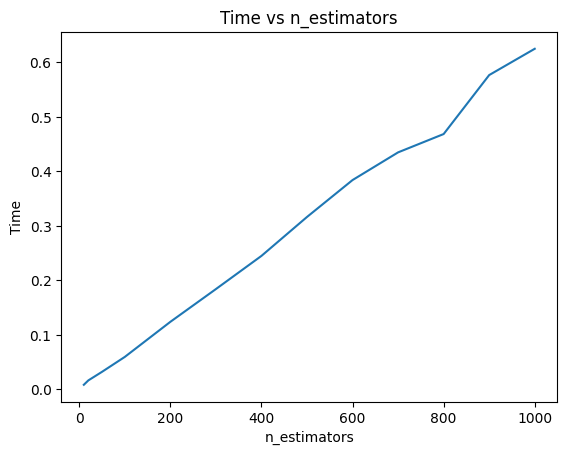

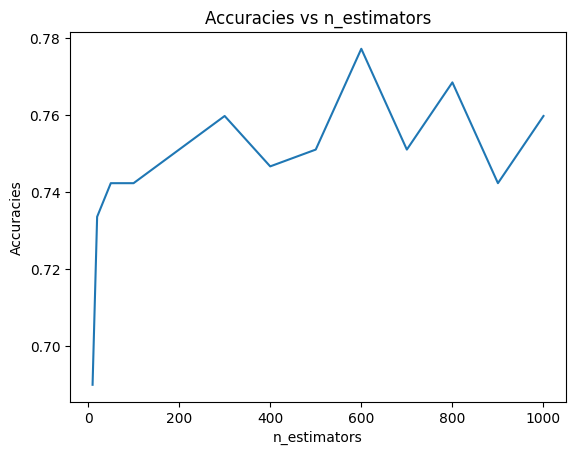

MAX ACCURACY: 0.777292576419214, NUMBER OF ESTIMATORS: 600


In [617]:
n_estimators = [10, 20, 50 , 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
times = []
accuracies = []

for n_estimator in n_estimators:
    time1 = time()
    ensemble_models, performances = AdaBoost(X_train, y_train, n_estimator)
    time2 = time()
    preds = AdaBoost_predict(X_val, ensemble_models, performances)
    val_accuracy = (preds == y_val).mean()
    times.append(time2 - time1)
    accuracies.append(val_accuracy)

plt.plot(n_estimators, times)
plt.title('Time vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Time')
plt.show()

plt.figure()

plt.plot(n_estimators, accuracies)
plt.title('Accuracies vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracies')
plt.show()

print(f'MAX ACCURACY: {accuracies[np.argmax(accuracies)]}, NUMBER OF ESTIMATORS: {n_estimators[np.argmax(accuracies)]}')

As we can see, after a certain number of estimators the accuracy starts to drop, so having too many is not a good thing either.

Now let us implement the gradient boosting trees for comparasion.

In [618]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def log_odds(p):
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    return np.log(p / (1 - p))

In [619]:
def GradientBoosting(X, y, n_estimators, lr):
    predictions = log_odds(np.mean(y))*np.ones_like(y)
    ensemble_model = []

    for _ in range(n_estimators):
        residual = y - sigmoid(predictions)

        model = DecisionTreeRegressor(max_depth=3)
        model.fit(X, residual)

        predictions += lr*model.predict(X)

        ensemble_model.append(model)

    return ensemble_model, log_odds(np.mean(y))


def GradientBoosting_predict(X, ensemble_models, start, lr):
    start = start * np.ones((len(X)))
    for model in ensemble_models:
        start += lr*model.predict(X)

        predictions = sigmoid(start)

        predictions[predictions>0.5] = 1
        predictions[predictions<=0.5] = 0

    return predictions

In [620]:
ensemble_models, start = GradientBoosting(X_train, y_train, 300, 0.1)
y_pred = GradientBoosting_predict(X_test, ensemble_models, start, 0.1)
val_accuracy = (y_pred == y_test).mean()
print(val_accuracy)
print('CONFUSION MATRIX FOR GRADIENT BOOST')
print(confusion_matrix(y_pred, y_test))

0.7807017543859649
CONFUSION MATRIX FOR GRADIENT BOOST
[[36  9]
 [16 53]]


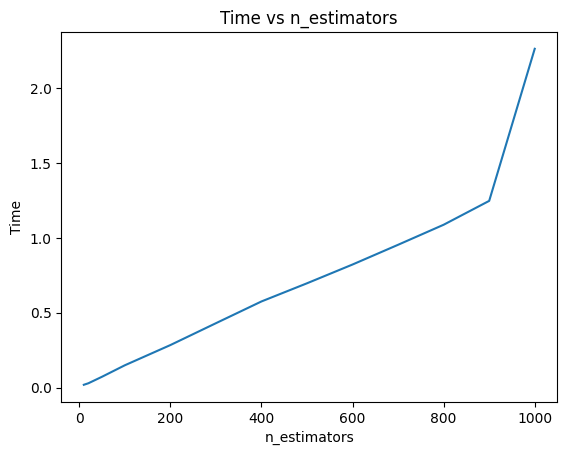

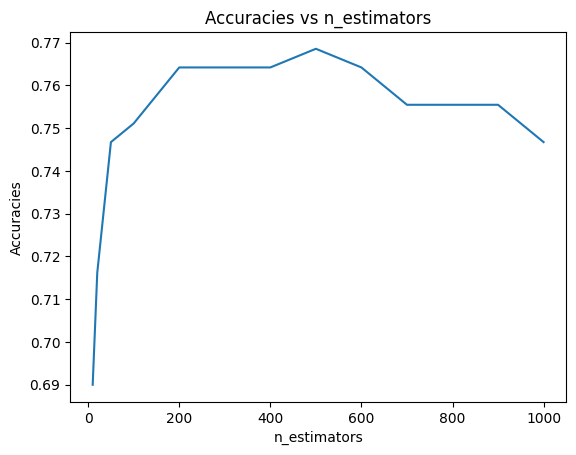

MAX ACCURACY: 0.7685589519650655, NUMBER OF ESTIMATORS: 500


In [612]:
n_estimators = [10, 20, 50 , 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
times = []
accuracies = []

for n_estimator in n_estimators:
    time1 = time()
    ensemble_models, performances = GradientBoosting(X_train, y_train, n_estimator, 0.1)
    time2 = time()
    preds = GradientBoosting_predict(X_val, ensemble_models, performances, 0.1)
    val_accuracy = (preds == y_val).mean()
    times.append(time2 - time1)
    accuracies.append(val_accuracy)

plt.plot(n_estimators, times)
plt.title('Time vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Time')
plt.show()

plt.figure()

plt.plot(n_estimators, accuracies)
plt.title('Accuracies vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracies')
plt.show()

print(f'MAX ACCURACY: {accuracies[np.argmax(accuracies)]}, NUMBER OF ESTIMATORS: {n_estimators[np.argmax(accuracies)]}')

As we can see, the accuracy starts dropping after a large number of n estimators

For the analysis of the mistakes made by the above models, we have printed the confusion matrics for the 3 kinds of models.

Also, due to lack of the ability to interpret an ensemble of decision trees compared to a single decision tree, analyzing the areas of mistake is difficult. Though the possible areas where these models go wrong is due to noisy data and outliers as well as the affect of noisy weights. Also since the individual trees of the random forest tend to overfit, they can tend to misclassify data it has never seen before

Now let us implement the sam thing for regression now.

In [580]:
housing_data = pd.read_csv('HousingData.csv')
print(housing_data.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  


In [581]:
feature_columns = housing_data.columns.tolist()

imputer = SimpleImputer(strategy='mean')
data_housing = pd.DataFrame(imputer.fit_transform(housing_data), columns=housing_data.columns)

scaler = StandardScaler()
data_housing = pd.DataFrame(scaler.fit_transform(data_housing[feature_columns[:-1]]), columns=feature_columns[:-1])
data_housing = pd.concat([data_housing, housing_data['MEDV']], axis = 1)

Train_df, rest_df = train_test_split(data_housing, test_size=0.3)
Test_df, Val_df = train_test_split(rest_df, test_size=0.2/0.3)


X_train = Train_df[feature_columns[:-1]].to_numpy()
X_val = Val_df[feature_columns[:-1]].to_numpy()
X_test = Test_df[feature_columns[:-1]].to_numpy()

Y_train = Train_df[feature_columns[-1]].to_numpy()
Y_val = Val_df[feature_columns[-1]].to_numpy()
Y_test = Test_df[feature_columns[-1]].to_numpy()

In [582]:
class TreeRegressor:

    def __init__(self):
        self.model = DecisionTreeRegressor()
        self.name = 'Decision Tree'

    def fit(self, X, y):
        return self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

In [583]:
def bagging_ensemble(X, y, base_estimator, n_estimators, sample_fraction, bootstrap, voting):
    ensemble_models = []
    feature_indicies = []

    for _ in range(n_estimators):
        
        indicies = np.random.choice(len(X), int(len(X)*sample_fraction), replace = bootstrap)
        indicies_x = np.random.choice(X.shape[1], 5,replace = False)
        feature_indicies.append(indicies_x)

        X_train = X[indicies]
        X_train = X_train[:, indicies_x]
        y_train = y[indicies]
        

        base_model = base_estimator()
        base_model.fit(X_train, y_train)
        ensemble_models.append(base_model)

    

    def ensemble_predict(X):
        predictions = [np.squeeze(model.predict(X[:, feature_indicies[i]])) for i, model in enumerate(ensemble_models)]
        predictions = np.array(predictions)
        
        if voting == 'hard':
            predictions = np.mean(predictions, axis = 0)
            return predictions
        else:
            val_predictions = [np.squeeze(model.predict(X_val[:, feature_indicies[i]])) for i, model in enumerate(ensemble_models)]
            val_predictions = np.array(val_predictions)
            val_loss = np.reciprocal(np.array([mean_squared_error(Y_val, x) for x in val_predictions]))
            predictions = np.sum(predictions*val_loss[:, np.newaxis], axis = 0)/np.sum(val_loss)
            return predictions
            


    y_pred = ensemble_predict(X)
    accuracy = r2_score(y_pred, y)

    return ensemble_models, accuracy, feature_indicies

def ensemble_predict(X, ensemble_models, voting, feature_indicies):

        predictions = [np.squeeze(model.predict(X[:, feature_indicies[i]])) for i, model in enumerate(ensemble_models)]
        predictions = np.array(predictions)
        
        if voting == 'hard':
            predictions = np.mean(predictions, axis = 0)
            return predictions
        else:
            val_predictions = [np.squeeze(model.predict(X_val[:, feature_indicies[i]])) for i, model in enumerate(ensemble_models)]
            val_predictions = np.array(val_predictions)
            val_loss = np.reciprocal(np.array([mean_squared_error(Y_val, x) for x in val_predictions]))
            predictions = np.sum(predictions*val_loss[:, np.newaxis], axis = 0)/np.sum(val_loss)
            return predictions

In [584]:
def RandomForest_regressor(X_val, Y_val, n_estimators, n_fraction = 0.33, bootstrap = True, voting = 'hard'):
    base_estimator = TreeRegressor
    ensemble_models, train_accuracy, feature_indicies = bagging_ensemble(X_train, Y_train, base_estimator, n_estimators, n_fraction, bootstrap, voting)
    y_pred = ensemble_predict(X_val, ensemble_models, voting, feature_indicies)
    val_accuracy = r2_score(y_pred, Y_val)

    return ensemble_models, val_accuracy, train_accuracy

In [585]:
votings = ['hard', 'soft']
bootstraps = [True, False]
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
n_estimators = [5, 10, 15]

for voting in votings:
    for bootstrap in bootstraps:
        for sample_fraction in sample_fractions:
            for n_estimator in n_estimators:
                ensemble_models, val_accuracy, train_accuracy = RandomForest_regressor(X_val, Y_val, n_estimator, sample_fraction, bootstrap, voting)
                print('----------------')
                print(f'NUMBER OF ESTIMATORs: {n_estimator}')
                print(f'SAMPLE FRACTIONS: {sample_fraction}')
                print(f'BOOTSTRAP: {bootstrap}')
                print(f'VOTING: {voting}')
                print(f'TRAIN MSELoss: {train_accuracy}, VALIDATION MSELoss: {val_accuracy}')

----------------
NUMBER OF ESTIMATORs: 5
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN MSELoss: 0.32021683395673783, VALIDATION MSELoss: 0.4139053517622928
----------------
NUMBER OF ESTIMATORs: 10
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN MSELoss: 0.5125002564113252, VALIDATION MSELoss: 0.5058663140063837
----------------
NUMBER OF ESTIMATORs: 15
SAMPLE FRACTIONS: 0.15
BOOTSTRAP: True
VOTING: hard
TRAIN MSELoss: 0.5776513853187989, VALIDATION MSELoss: 0.4512358422006474
----------------
NUMBER OF ESTIMATORs: 5
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN MSELoss: 0.6833953168233081, VALIDATION MSELoss: 0.5083059124236425
----------------
NUMBER OF ESTIMATORs: 10
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN MSELoss: 0.7801631829259714, VALIDATION MSELoss: 0.6100706182100469
----------------
NUMBER OF ESTIMATORs: 15
SAMPLE FRACTIONS: 0.25
BOOTSTRAP: True
VOTING: hard
TRAIN MSELoss: 0.7393681126683127, VALIDATION MSELoss: 0.6449907635

Now, let us implement adaboost for this regression problem.

In [621]:
def AdaBoost_regressor(X, y, n_estimator):
    sample_weights = np.ones((len(X)))/len(X)
    ensemble_models = []
    performances = []
    
    for _ in range(n_estimator):
        model = DecisionTreeRegressor(max_depth=1)

        indicies = np.random.choice(len(X), int(len(X)*0.25), replace = True)
        X_train = X[indicies]
        Y_train = y[indicies]

        model.fit(X_train, Y_train, sample_weight = sample_weights[indicies])

        y_pred = model.predict(X)

        errors = np.abs(y_pred - y)/ np.max(np.abs(y_pred - y))
        error = np.sum(sample_weights*errors)

        if error >= 0.5:
            break

        performance = error/(1 - error)

        sample_weights *= (performance**(1 - errors))/np.sum(sample_weights*performance**(1-errors))

        ensemble_models.append(model)
        performances.append(performance)
    
    model_weights = np.log(1/np.array(performances))
        
    return ensemble_models, model_weights

def AdaBoost_regressor_predict(X, ensemble_models, performances):
    preds = np.zeros((X.shape[0], len(ensemble_models)))

    for i, model in enumerate(ensemble_models):
        preds[:, i] = performances[i] * model.predict(X)

    return np.median(preds, axis = 1)

In [623]:
ensemble_models, performances = AdaBoost_regressor(X_train, Y_train, 200)
preds = AdaBoost_regressor_predict(X_val, ensemble_models, performances)
val_accuracy = mean_squared_error(preds, Y_val)
print(val_accuracy)

0.9577254681445146


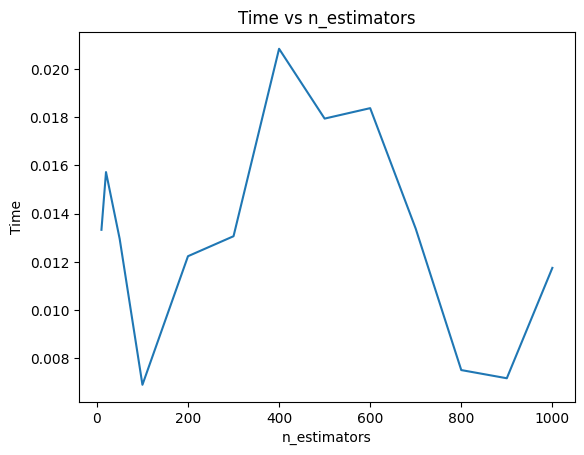

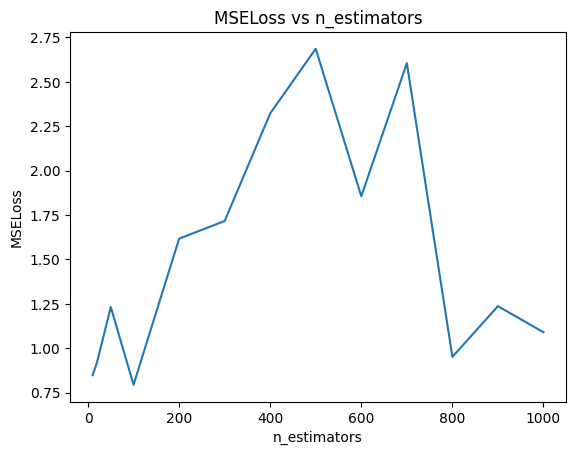

In [624]:
n_estimators = [10, 20, 50 , 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
times = []
accuracies = []

for n_estimator in n_estimators:
    time1 = time()
    ensemble_models, performances = AdaBoost_regressor(X_train, Y_train, n_estimator)
    time2 = time()
    preds = AdaBoost_regressor_predict(X_val, ensemble_models, performances)
    val_accuracy = mean_squared_error(preds, Y_val)
    times.append(time2 - time1)
    accuracies.append(val_accuracy)

plt.plot(n_estimators, times)
plt.title('Time vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Time')
plt.show()

plt.figure()

plt.plot(n_estimators, accuracies)
plt.title('MSELoss vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('MSELoss')
plt.show()

Now let us implement the Gradient boost algorithm for regression.

In [589]:
def GradientBoosting_regressor(X, y, n_estimator, lr):
    predictions = np.mean(y)*np.ones_like(y)
    ensemble_model = []

    for _ in range(n_estimator):
        residual = y - predictions

        model = DecisionTreeRegressor(max_depth=3)
        model.fit(X, residual)

        predictions += lr*model.predict(X)

        ensemble_model.append(model)

    return ensemble_model, np.mean(y)



def GradientBoosting_regressor_predict(X, ensemble_models, start, lr):
    start = start * np.ones((len(X)))
    for model in ensemble_models:
        start += lr*model.predict(X)

    return start

In [590]:
ensemble_models, performances = GradientBoosting_regressor(X_train, Y_train, 200, 0.1)
preds = GradientBoosting_regressor_predict(X_val, ensemble_models, performances, 0.1)
val_accuracy = r2_score(preds, Y_val)
print(val_accuracy)

0.9047338002526368


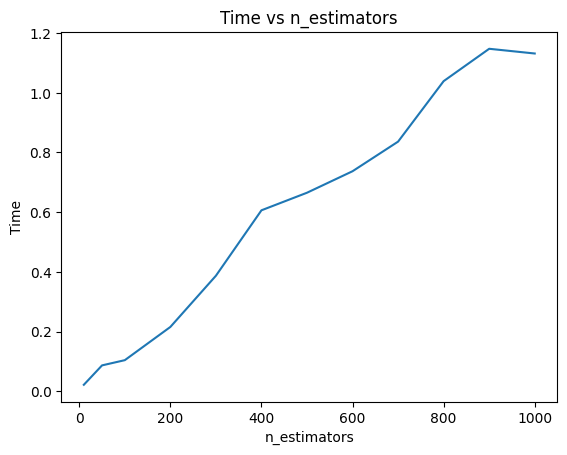

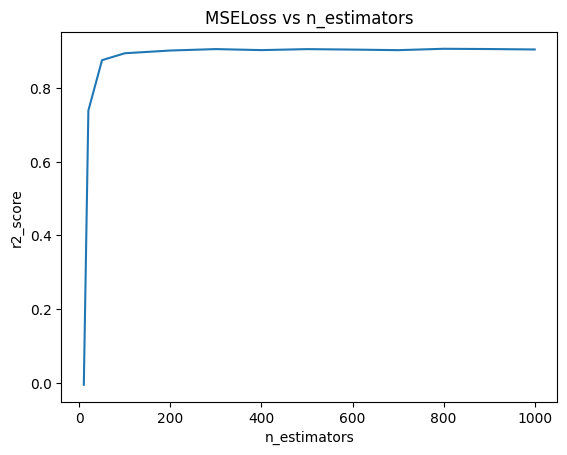

In [593]:
n_estimators = [10, 20, 50 , 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
times = []
accuracies = []

for n_estimator in n_estimators:
    time1 = time()
    ensemble_models, performances = GradientBoosting_regressor(X_train, Y_train, n_estimator, 0.1)
    time2 = time()
    preds = GradientBoosting_regressor_predict(X_val, ensemble_models, performances, 0.1)
    val_accuracy = r2_score(preds, Y_val)
    times.append(time2 - time1)
    accuracies.append(val_accuracy)

plt.plot(n_estimators, times)
plt.title('Time vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Time')
plt.show()

plt.figure()

plt.plot(n_estimators, accuracies)
plt.title('MSELoss vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('r2_score')
plt.show()

As we can see, the loss decreases for a large number of estimators